In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import describe, randint
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import scipy.sparse

sns.set()

# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

# 3.

In [164]:
def random_neighbour(points):

    # Getting dimensions of points
    dimension = np.shape(points)
    
    # Generate if going up or down, do this for all points
    up_or_down = 2*np.random.randint(2, size=dimension[0]) - 1
    
    # Generate which diretion to go in for all points
    direction = np.random.randint(dimension[1], size=dimension[0])
    
    # Create new matrix, create a binary matrix of the direction
    indptr = range(len(direction)+1)
    data = np.ones(len(direction))
    points_to_change = scipy.sparse.csr_matrix((data, direction, indptr)).toarray()
    
    # Add the binary matrix multiplied by direction to the old points
    new_points = points + (points_to_change.T*up_or_down).T
    
    return new_points

def random_neighbour_avoiding(random_walks):
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    new_points = []
    
    # Iterate over random walks
    for random_walk in random_walks_list:
        
        print("Random walk")
        print(random_walk)
        
        last_point = random_walk[-1]
        viable_points = []
        
        dimension = np.shape(last_point)[0]
        
        for n in range(dimension):
            
            change = np.zeros(dimension)
            change[n] = 1
            
            point_up = last_point - change
            point_down = last_point + change
            
            viable_points.append(list(point_up))
            viable_points.append(list(point_down))
        
        for point in viable_points:
            print(f'Finns {point} i: {point in random_walk}')
        
        viable_points = list(filter(lambda x: x in random_walk, viable_points))
        length = len(viable_points)
        
        if length == 0:
            new_points.append(last_point)
        else:   
            new_point_index = np.random.randint(length, size=1)[0]
            new_points.append(viable_points[new_point_index])
        
    return new_points

def is_self_avoiding(random_walk):
    return int(len(np.unique(random_walk, axis=0)) == len(random_walk))

def generate_weights(random_walks, weights):
    
    # Get indexes where weights is different from zero
    indexes = np.nonzero(weights)[0]
    
    # Create new weights
    new_weights = np.zeros(len(weights))
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    # Looping over wieghts different from zero
    for index in indexes:
        new_weights[index] = is_self_avoiding(random_walks_list[index])
        
    return new_weights      

def init_walk (d, k, N, self_avoiding = False):
    
    # The random_walk array has the following structure compared 
    # to the lecture notes random_walk[k][i][d], where:
    # k = step number k
    # i = simulation number
    # d = dimension 
    
    random_walks = []
    weights = [[1] * N]
    
    random_walks.append(np.zeros((N, d)))
    
    for step in range(k):
        if self_avoiding:
            step_all = random_neighbour_avoiding(random_walks)
        else:
            step_all = random_neighbour(random_walks[step])
        random_walks.append(step_all)
        weights.append(generate_weights(random_walks, weights[step]))
        print("-", end = '')
        
    return random_walks, weights

In [ ]:
random

Random walk
[[0. 0.]]
Finns [-1.0, 0.0] i: True
Finns [1.0, 0.0] i: True
Finns [0.0, -1.0] i: True
Finns [0.0, 1.0] i: True
-Random walk
[[ 0.  0.]
 [ 0. -1.]]
Finns [-1.0, -1.0] i: True
Finns [1.0, -1.0] i: True
Finns [0.0, -2.0] i: True
Finns [0.0, 0.0] i: True
-Random walk
[[ 0.  0.]
 [ 0. -1.]
 [ 1. -1.]]
Finns [0.0, -1.0] i: True
Finns [2.0, -1.0] i: True
Finns [1.0, -2.0] i: True
Finns [1.0, 0.0] i: True
-Random walk
[[ 0.  0.]
 [ 0. -1.]
 [ 1. -1.]
 [ 1. -2.]]
Finns [0.0, -2.0] i: True
Finns [2.0, -2.0] i: True
Finns [1.0, -3.0] i: True
Finns [1.0, -1.0] i: True
-Random walk
[[ 0.  0.]
 [ 0. -1.]
 [ 1. -1.]
 [ 1. -2.]
 [ 1. -3.]]
Finns [0.0, -3.0] i: True
Finns [2.0, -3.0] i: True
Finns [1.0, -4.0] i: True
Finns [1.0, -2.0] i: True
-

array([0., 0., 0., 0., 0., 0.])

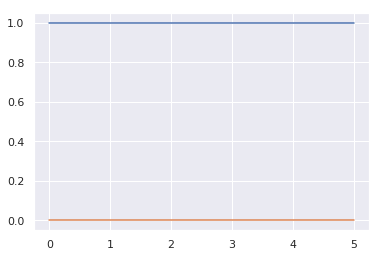

In [165]:
walks, weights = init_walk(2, 5, 1, self_avoiding=True)
prob = np.mean(weights, axis=1)
var = np.var(weights, axis=1)
plt.plot(range(len(weights)), prob)
plt.plot(range(len(var)), var)
var

In [ ]:
walks, weights = init_walk(2, 20, 10**5, self_avoiding=False)
prob = np.mean(weights, axis=1)
var = np.var(weights, axis=1)
plt.plot(range(len(weights)), prob)
plt.plot(range(len(var)), var)
var

In [151]:
rw = [[0, 0], [1, 0,]]
points = [[0, 0], [1, 2,]]
points = list(filter(lambda x: x not in rw, points))

In [173]:
[0, 3] in [[0, 1.00], [1,3]]

False

In [174]:
walks

[array([[0., 0.]]),
 [[0.0, -1.0]],
 [[1.0, -1.0]],
 [[1.0, -2.0]],
 [[1.0, -3.0]],
 [[2.0, -3.0]]]